# OUTDATED, the examples moved to the gallery
## See https://empymod.github.io/emg3d-gallery

----

# Transient CSEM for a layered, marine model

Example how to use `emg3d` to model time-domain data using FFTLog. 


**Requires**
- **emg3d >= 0.9.0**
- `empymod`, `discretize`

In [1]:
import emg3d
import empymod
import discretize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Name is used to store the data for each frequency.
name = 'Marine-1D'

In [2]:
# Style adjustments
%matplotlib notebook
plt.style.use('ggplot')
clim = np.log10([0.2, 200])

## Model and Survey

### Model
- 1 km water depth, 0.3 Ohm.m.
- Target of 100 Ohm.m, 500 m thick, 1 km below seafloor.
- Air set to 1e8 Ohm.m, background is 1 Ohm.m.

### Survey
- Source at origin, 50 m above seafloor.
- Receiver on the seafloor at an inline-offset of 4 km.
- Both source and receiver are x-directed electric dipoles.

In [3]:
src = [0, 0, 950]
rec = [4000, 0, 1000]
res = np.array([1e8, 0.3, 1, 100, 1])
depth = np.array([0, 1000, 2000, 2500])

Here we create a dummy mesh with one cell in x- and y-directions, and our 1D model in z-direction. From this, we can interpolate the model to our varying meshes afterwards.

<IPython.core.display.Javascript object>


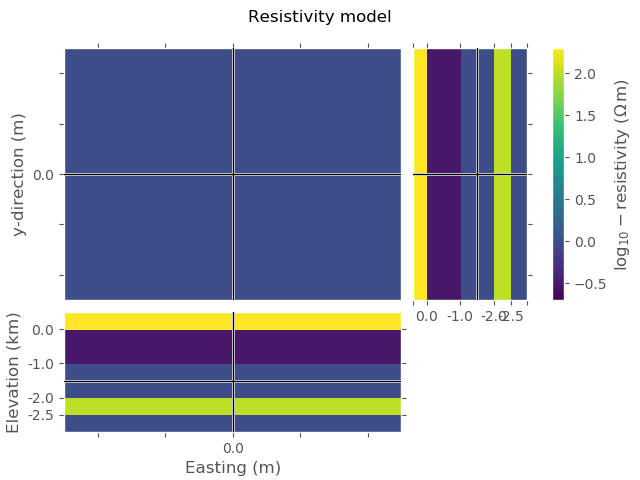

In [4]:
# Create the mesh.
orig_mesh = discretize.TensorMesh(
    [[1,], [1,], np.r_[1000, np.diff(depth)[::-1], 1000]],
    x0=('C', 'C', -(depth[-1]+1000)))

# Create a resistivity model using the 1D model and the above mesh.
orig_model = emg3d.utils.Model(orig_mesh, res_x=np.array(res)[::-1])

# QC.
orig_mesh.plot_3d_slicer(np.log10(orig_model.res_x), zlim=[-3000, 500], clim=clim)

# Get figure and axes
fig = plt.gcf()
axs = fig.get_children()

fig.suptitle(r'Resistivity model')

# Adjust the y-labels on the first subplot (XY)
axs[1].set_yticks([-0.4, -0.2, 0, 0.2, 0.4])
axs[1].set_yticklabels(['', '', '0.0', '', ''])
axs[1].set_ylabel('y-direction (m)')

# Adjust x- and y-labels on the second subplot (XZ)
axs[2].set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
axs[2].set_xticklabels(['', '', '0.0', '', ''])
axs[2].set_xlabel('Easting (m)')

#plt.setp(axs[2].yaxis.get_majorticklabels(), rotation=90)
axs[2].set_yticks([0, -1000, -2000, -2500])
axs[2].set_yticklabels(['$0.0$', '-1.0', '-2.0', '-2.5'])
axs[2].set_ylabel('Elevation (km)')

# Adjust x-labels on the third subplot (ZY)
axs[3].set_xticks([400, 0, -1000, -2000, -2500, -3000])
axs[3].set_xticklabels(['', '$0.0$', '-1.0', '-2.0', '-2.5'])

# Adjust colorbar
axs[4].set_ylabel(r'$\rm{log}_{10}-$resistivity ($\Omega\,$m)')

# Ensure sufficient margins so nothing is clipped
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9)

## Fourier Transform parameters

We only calculate frequencies $0.003 < f < 5$ Hz, which yields enough precision for our purpose.

This means, instead of 30 frequencies from 0.00002 - 12.6 Hz, we only need 16 frequencies from 0.003 - 3.2 Hz.

In [5]:
# Define desired times.
time = np.logspace(-1, 2, 201)

# Initiate a Fourier instance
Fourier = emg3d.utils.Fourier(
    time=time,
    fmin=0.003,
    fmax=5,
    ft='fftlog',  # Fourier transform to use
    ftarg={'pts_per_dec': 5, 'add_dec': [-2, 1], 'q': 0},
)

# Dense frequencies for comparison reasons
freq_dense = np.logspace(np.log10(Fourier.freq_req.min()), np.log10(Fourier.freq_req.max()), 301)

   time        [s] :  0.1 - 100 : 201  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  5
     > add_dec     :  [-2.  1.]
     > q           :  0.0
   Req. freq  [Hz] :  2.00364E-05 - 12.6421 : 30  [min-max; #]
   Calc. freq [Hz] :  0.00317556 - 3.17556 : 16  [min-max; #]


## Frequency-domain calculation

In [6]:
# To store the info of each frequency.
values = {}

In [7]:
gridinput = {
    'min_width': 100.,    # We fix the cell width within the survey domain to 100 m.
    'return_info': True,  # To get back some information for later.
}

# Start the timer.
runtime = emg3d.utils.Time()

# Loop over frequencies, going from high to low.
for fi, frq in enumerate(Fourier.freq_calc[::-1]):
    print(f"\n{15*'='} {fi+1:2}/{Fourier.freq_calc.size} {15*'='} {frq:10.6f} Hz {40*'='}\n")
    
    # Key is used to store the data etc.
    key = int(frq*1e6)
          
    # Initiate log for this frequency.
    values[key] = {}
    values[key]['freq'] = frq

    # Get cell widths and origin in each direction
    # - source location is grid center.
    # - We use 100 Ohm.m for skin depth for each direction where there is air.
    #   Should be fine, as we have 1 km of water column.
    xx, x0, hix = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 100.], fixed=src[0], domain=[-100, 4100], **gridinput)
    yy, y0, hiy = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 100.], fixed=src[1], domain=[0, 0], **gridinput)
    zz, z0, hiz = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 1., 100.], domain=[-2500, 0], **gridinput,
        fixed=[-depth[1], -depth[0], -depth[-1]])
    
    # Store values in log.
    values[key]['alpha'] = [np.min([hix['amin'], hiy['amin'], hiz['amin']]),
                            np.max([hix['amax'], hiy['amax'], hiz['amax']])]
    values[key]['dminmax'] = [np.min([hix['dmin'], hiy['dmin'], hiz['dmin']]),
                              np.max([hix['dmax'], hiy['dmax'], hiz['dmax']])]

    # Initiate mesh.
    grid = discretize.TensorMesh([xx, yy, zz], x0=np.array([x0, y0, z0]))
    values[key]['nC'] = grid.nC  # Store number of cells in log.

    # Interpolate the starting electric field from the last one (can speed-up the calculation).
    # Only for lower frequencies.
    if fi == 0 or frq > 1:
        efield = emg3d.utils.Field(grid, freq=frq)
    else:
        efield = emg3d.utils.grid2grid(old_grid, efield, grid, method='cubic', extrapolate=False)
        efield = emg3d.utils.Field(grid, efield, freq=frq)

    # Generate model (interpolate on log-scale from our coarse model).
    res_x = 10**emg3d.utils.grid2grid(orig_mesh, np.log10(orig_model.res_x), grid, 'volume')
    res_y = 10**emg3d.utils.grid2grid(orig_mesh, np.log10(orig_model.res_y), grid, 'volume')
    res_z = 10**emg3d.utils.grid2grid(orig_mesh, np.log10(orig_model.res_z), grid, 'volume')
    model = emg3d.utils.Model(grid, res_x, res_y, res_z)
    # grid.plot_3d_slicer(np.log10(model.res_x), zlim=[-3000, 500], clim=clim)  # QC

    # Define source.
    sfield = emg3d.utils.get_source_field(
        grid, [src[0], src[1], -src[2], 0, 0], frq, strength=0)

    # Solve the system.
    info = emg3d.solver.solver(
        grid, model, sfield, efield=efield, verb=2, return_info=True,
        sslsolver=True,  semicoarsening=True, linerelaxation=True,
    )

    # Store info
    values[key]['info'] = info

    # Save result for this frequency.
    grid._vol = None  # Saves space, not needed.
    emg3d.utils.data_write(name+'_'+str(key), ['grid', 'efield'], [grid, efield],
                           path='data/time', exists=-1)
    
    print(f"\n   {info['exit_message']}; {info['it_mg']:g}/{info['it_ssl']:g} iteration(s); "
          f"{info['time']} s; alpha = {values[key]['alpha'][0]:.3f} / {values[key]['alpha'][1]:.3f}")

    # Store the grid for the interpolation.
    old_grid = grid

# Stop the timer.
total_time = runtime.runtime


===============  1/16 ===============   3.175559 Hz ========================================

   Skin depth (m/l-r)  [m] : 155 / 2824
   Survey domain       [m] : -100 - 4100
   Calculation domain  [m] : -17046 - 21046
   Final extent        [m] : -17840 - 21840
   Min/max cell width  [m] : 100 / 100 / 5521
   Alpha survey/calc       : 1.000 / 1.440
   Number of cells (s/c/r) : 64 (42/22/0)

   Skin depth (m/l-r)  [m] : 155 / 2824
   Survey domain       [m] : 0 - 0
   Calculation domain  [m] : -16946 - 16946
   Final extent        [m] : -17840 - 17840
   Min/max cell width  [m] : 100 / 100 / 5521
   Alpha survey/calc       : 1.000 / 1.440
   Number of cells (s/c/r) : 24 (2/22/0)

   Skin depth (m/l/r)  [m] : 155 / 282 / 2824
   Survey domain       [m] : -2500 - 0
   Calculation domain  [m] : -4195 - 16946
   Final extent        [m] : -4478 - 17000
   Min/max cell width  [m] : 100 / 100 / 5767
   Alpha survey/calc       : 1.000 / 1.500
   Number of cells (s/c/r) : 40 (25/15/0)


:: emg


:: emg3d START :: 12:05:22 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 2
   Original grid  :  80 x  32 x  48     => 122,880 cells
   Coarsest grid  :   5 x   2 x   3     => 30 cells
   Coarsest level :   4 ;   4 ;   4   


   > CONVERGED
   > Solver steps     : 2
   > MG prec. steps   : 10
   > Final rel. error : 9.162e-08

:: emg3d END   :: 12:05:39 :: runtime = 0:00:17

   > File exists, overwriting it.

   CONVERGED; 10/2 iteration(s); 17 s; alpha = 1.000 / 1.430

===============  7/16 ===============   0.200364 Hz ========================================

   Skin depth (m/l-r)  [m] : 616 / 11244
   Survey domain       [m] : -100 - 4100
   Calculation domain  [m] : -67563 - 71563
   Final extent        [m] : -71138 - 75138
   Min/max cell width  [m] : 100 / 100 / 16910
   Alpha survey/calc    


:: emg3d START :: 12:08:01 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 2
   Original grid  :  80 x  40 x  64     => 204,800 cells
   Coarsest grid  :   5 x   5 x   2     => 50 cells
   Coarsest level :   4 ;   3 ;   5   


   > CONVERGED
   > Solver steps     : 2
   > MG prec. steps   : 13
   > Final rel. error : 2.548e-07

:: emg3d END   :: 12:08:42 :: runtime = 0:00:40

   > File exists, overwriting it.

   CONVERGED; 13/2 iteration(s); 40 s; alpha = 1.000 / 1.390

=============== 12/16 ===============   0.020036 Hz ========================================

   Skin depth (m/l-r)  [m] : 1948 / 35556
   Survey domain       [m] : -100 - 4100
   Calculation domain  [m] : -213438 - 217438
   Final extent        [m] : -235043 - 239043
   Min/max cell width  [m] : 100 / 100 / 68417
   Alpha survey/cal


:: emg3d START :: 12:12:19 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 2
   Original grid  :  80 x  40 x  64     => 204,800 cells
   Coarsest grid  :   5 x   5 x   2     => 50 cells
   Coarsest level :   4 ;   3 ;   5   


   > CONVERGED
   > Solver steps     : 4
   > MG prec. steps   : 22
   > Final rel. error : 1.822e-07

:: emg3d END   :: 12:13:27 :: runtime = 0:01:07

   > File exists, overwriting it.

   CONVERGED; 22/4 iteration(s); 67 s; alpha = 1.000 / 1.490


In [8]:
print(f"\n                **** TOTAL RUNTIME :: {total_time} ****\n")
for key, value in values.items():
    print(f"  {value['freq']:7.3f} Hz: {value['info']['it_mg']:2g}/{value['info']['it_ssl']:g} it; "
          f"{value['info']['time']:4.0f} s; "
          f"a: {value['alpha'][0]:.3f} / {value['alpha'][1]:.3f} ; "
          f"nC: {value['nC']:8,.0f}; "
          f"a: {value['dminmax'][0]:5.0f} / {value['dminmax'][1]:7.0f}")


                **** TOTAL RUNTIME :: 0:09:08 ****

    3.176 Hz:  7/1 it;    7 s; a: 1.000 / 1.500 ; nC:   61,440; a:   100 /    5767
    2.004 Hz:  7/1 it;    9 s; a: 1.000 / 1.470 ; nC:   73,728; a:   100 /    6926
    1.264 Hz:  7/1 it;   15 s; a: 1.000 / 1.330 ; nC:  122,880; a:   100 /    7207
    0.798 Hz:  7/1 it;   17 s; a: 1.000 / 1.350 ; nC:  122,880; a:   100 /    9016
    0.503 Hz:  7/1 it;   14 s; a: 1.000 / 1.380 ; nC:  122,880; a:   100 /   12537
    0.318 Hz: 10/2 it;   17 s; a: 1.000 / 1.430 ; nC:  122,880; a:   100 /   21382
    0.200 Hz: 13/2 it;   21 s; a: 1.000 / 1.470 ; nC:  122,880; a:   100 /   22001
    0.126 Hz: 13/2 it;   23 s; a: 1.000 / 1.500 ; nC:  122,880; a:   100 /   29194
    0.080 Hz: 13/2 it;   45 s; a: 1.000 / 1.480 ; nC:  163,840; a:   100 /   35804
    0.050 Hz: 13/2 it;   49 s; a: 1.000 / 1.370 ; nC:  204,800; a:   100 /   39600
    0.032 Hz: 13/2 it;   40 s; a: 1.000 / 1.390 ; nC:  204,800; a:   100 /   52153
    0.020 Hz: 13/2 it;   46 s; a: 

### Load data, interpolate at receiver location

In [9]:
# We initiate with zeros.
data = np.zeros(Fourier.freq_calc.size, dtype=complex)

# Loop over frequencies.
for fi, frq in enumerate(Fourier.freq_calc):
    key = int(frq*1e6)
    grid, efield = emg3d.utils.data_read(name+'_'+str(key), ['grid', 'efield'], path='data/time')
    data[fi] = emg3d.utils.get_receiver(grid, efield.fx, (rec[0], rec[1], -rec[2]))

### Interpolate missing frequecies and calculate analytical result

In [10]:
data_int = Fourier.interpolate(data)

# Calculate analytical result using empymod (epm)
epm_req = empymod.dipole(src, rec, depth, res, Fourier.freq_req, verb=1)
epm_calc = empymod.dipole(src, rec, depth, res, Fourier.freq_calc, verb=1)
epm_dense = empymod.dipole(src, rec, depth, res, freq_dense, verb=1)

### Plot frequency-domain result

<IPython.core.display.Javascript object>


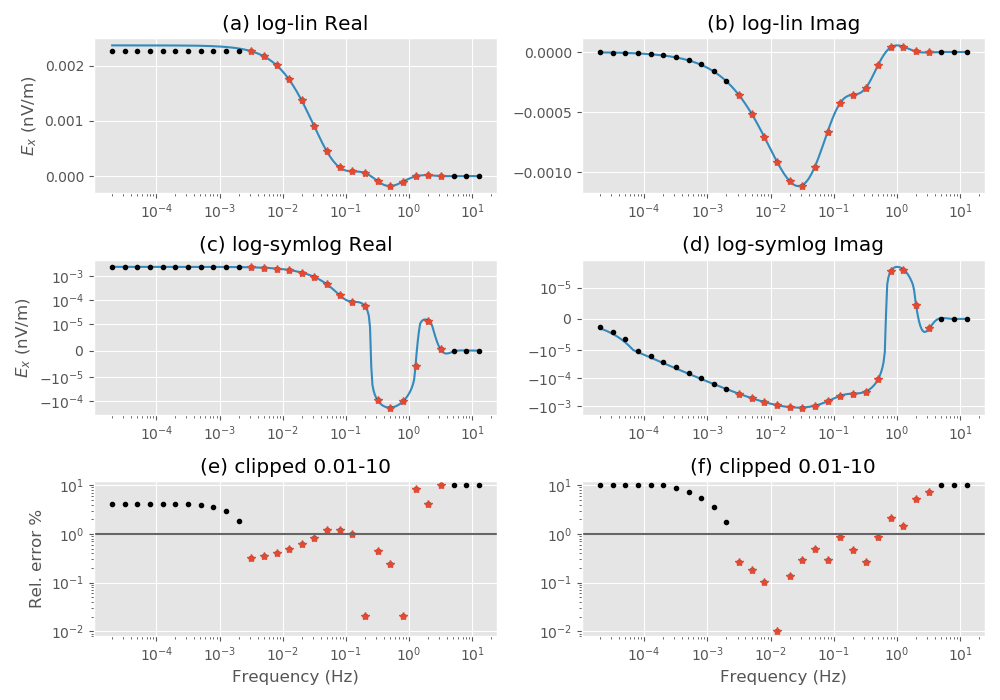

In [11]:
plt.figure(figsize=(10, 7))

# Real, log-lin
ax1 = plt.subplot(321)
plt.title('(a) log-lin Real')
plt.plot(freq_dense, 1e9*epm_dense.real, 'C1')
plt.plot(Fourier.freq_req, 1e9*data_int.real, 'k.', label='interpolated')
plt.plot(Fourier.freq_calc, 1e9*data.real, 'C0*')
plt.ylabel('$E_x$ (nV/m)')
plt.xscale('log')

# Real, log-symlog
ax3 = plt.subplot(323, sharex=ax1)
plt.title('(c) log-symlog Real')
plt.plot(freq_dense, 1e9*epm_dense.real, 'C1')
plt.plot(Fourier.freq_req, 1e9*data_int.real, 'k.')
plt.plot(Fourier.freq_calc, 1e9*data.real, 'C0*')
plt.ylabel('$E_x$ (nV/m)')
plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-5)

# Real, error
ax5 = plt.subplot(325, sharex=ax3)
plt.title('(e) clipped 0.01-10')

# Calculate the error
err_int_r =  np.clip(100*abs((data_int.real-epm_req.real) /
                             epm_req.real), 0.01, 10)
err_cal_r = np.clip(100*abs((data.real-epm_calc.real) /
                            epm_calc.real), 0.01, 10)

plt.ylabel('Rel. error %')
plt.plot(Fourier.freq_req, err_int_r, 'k.')
plt.plot(Fourier.freq_calc, err_cal_r, 'C0*')
plt.axhline(1, color='.4')

plt.xscale('log')
plt.yscale('log')
plt.ylim([0.008, 12])
plt.xlabel('Frequency (Hz)')

# Imaginary, log-lin
ax2 = plt.subplot(322)
plt.title('(b) log-lin Imag')
plt.plot(freq_dense, 1e9*epm_dense.imag, 'C1')
plt.plot(Fourier.freq_req, 1e9*data_int.imag, 'k.', label='interpolated')
plt.plot(Fourier.freq_calc, 1e9*data.imag, 'C0*')
plt.xscale('log')

# Imaginary, log-symlog
ax4 = plt.subplot(324, sharex=ax2)
plt.title('(d) log-symlog Imag')
plt.plot(freq_dense, 1e9*epm_dense.imag, 'C1')
plt.plot(Fourier.freq_req, 1e9*data_int.imag, 'k.')
plt.plot(Fourier.freq_calc, 1e9*data.imag, 'C0*')

plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-5)

# Imaginary, error
ax6 = plt.subplot(326, sharex=ax2)
plt.title('(f) clipped 0.01-10')

# Calculate error
err_int_i =  np.clip(100*abs((data_int.imag-epm_req.imag) /
                             epm_req.imag), 0.01, 10)
err_cal_i = np.clip(100*abs((data.imag-epm_calc.imag) /
                            epm_calc.imag), 0.01, 10)

plt.plot(Fourier.freq_req, err_int_i, 'k.')
plt.plot(Fourier.freq_calc, err_cal_i, 'C0*')
plt.axhline(1, color='.4')

plt.xscale('log')
plt.yscale('log')
plt.ylim([0.008, 12])
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
#plt.savefig('./'+name+'_freq.pdf')
plt.show()

## Fourier Transform

Carry-out Fourier transform, calculate analytical result

In [12]:
# Calculate corresponding time-domain signal.
data_time = Fourier.freq2time(data, rec[0])

# Analytical result
epm_time_precise = empymod.dipole(src, rec, depth, res, time, signal=0, verb=1)
epm_time = empymod.dipole(src, rec, depth, res, time, signal=0, ft=Fourier.ft, ftarg=Fourier.ftarg, verb=1)

### Plot time-domain result

<IPython.core.display.Javascript object>


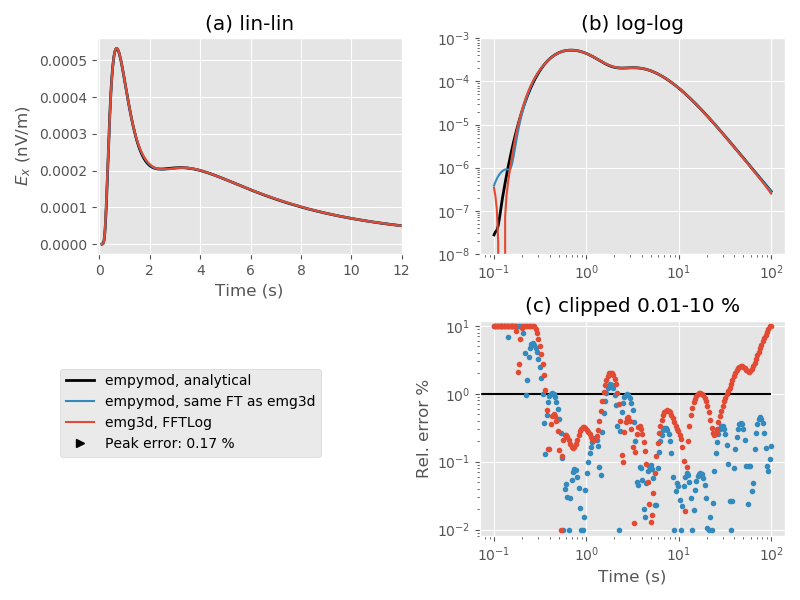

In [13]:
fig = plt.figure(figsize=(8, 6))

# lin-lin
plt.subplot(221)
plt.title('(a) lin-lin')
plt.plot(time, epm_time_precise*1e9, 'k', lw=2)
plt.plot(time, epm_time*1e9, 'C1')
plt.plot(time, data_time*1e9, 'C0')
plt.ylabel('$E_x$ (nV/m)')
plt.xlim([-0.1, 12])
plt.xlabel('Time (s)')

# log-log
ax2 = plt.subplot(222)
plt.title('(b) log-log')
plt.plot(time, epm_time_precise*1e9, 'k', lw=2, label='empymod, analytical')
plt.plot(time, epm_time*1e9, 'C1', label='empymod, same FT as emg3d')
plt.plot(time, data_time*1e9, 'C0', label='emg3d, FFTLog')
plt.plot(-1, 1e9, 'k>', label=f"Peak error: {100*(max(data_time)-max(epm_time_precise))/max(epm_time_precise):.2f} %")
#plt.xlim([1.5e-2, 2e0])
plt.ylim([1e-8, 1e-3])
plt.xscale('log')
plt.yscale('log')

# Error
ax4 = plt.subplot(224, sharex=ax2)
plt.title('(c) clipped 0.01-10 %')

# Calculate error
err = np.clip(100*abs((data_time-epm_time_precise)/epm_time_precise), 0.01, 10)
err2 = np.clip(100*abs((epm_time-epm_time_precise)/epm_time_precise), 0.01, 10)

plt.loglog(time, err2, 'C1.')
plt.loglog(time, err, 'C0.')
plt.hlines(1, 0, 100)
plt.xlabel('Time (s)')
plt.ylabel('Rel. error %')
plt.ylim([0.008, 12])

plt.tight_layout()

# Plot peak error
ax2.legend(bbox_to_anchor=(-0.5, -0.5))

#plt.savefig('./'+name+'_time.pdf')
plt.show()

### Further explanations to the results in the above figure:

- The black line is a very accurate result using empymod and the following characteristics for the Fourier transform:
  - Filter: Key 201 CosSin (2012)
  - DLF type: Lagged Convolution
  - Required frequencies: 251, from 1.5e-9 to 1.8e6 Hz
- The blue result was equally obtained with empymod, but with the Fourier-transform parameters as used for `emg3d`, hence FFTLog with 5 pts per decade. However, in contrary to the red response, all frequencies are calculated, with a very high precision.
- The red result is the result obtain with `emg3d`. 

## Plot result for a single frequency

In [14]:
pfreq = Fourier.freq_req[12]
print(f"Frequency: {pfreq:.5f} Hz")

Frequency: 0.00503 Hz


<IPython.core.display.Javascript object>


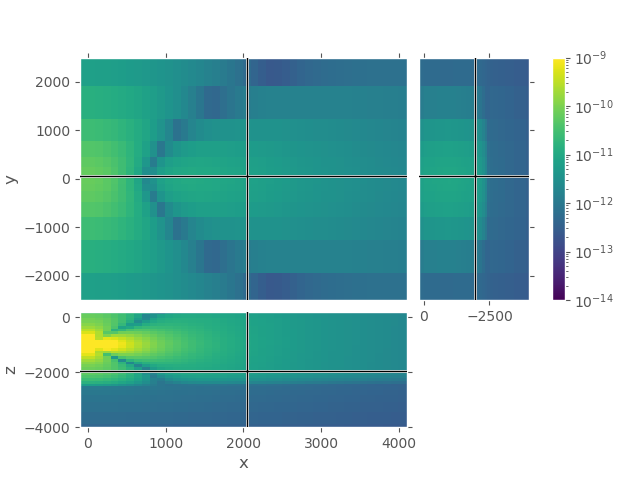

In [15]:
grid, efield = emg3d.utils.data_read(name+'_'+str(int(pfreq*1e6)), ['grid', 'efield'], path='data/time')
grid.plot_3d_slicer(
    efield.fx.ravel('F'), view='abs', vType='Ex', clim=[1e-14, 1e-9],
    xlim=[-100, 4100], ylim=[-2500, 2500], zlim=[-4000, 200],
    zslice=-2000,
    pcolorOpts={'norm': LogNorm()})

In [16]:
emg3d.Report([empymod, discretize])

--------------------------------------------------------------------------------
  Date: Fri Nov 08 12:13:30 2019 CET

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            1.10.2 : empymod
            0.4.10 : discretize
            1.17.3 : numpy
             1.3.1 : scipy
            0.46.0 : numba
             0.9.0 : emg3d
             7.9.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------